<a href="https://colab.research.google.com/github/Luana-lrb/LIPAI_Python/blob/main/onboarding/src/semana_8/Ex_5_e_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exercícios 5 e 6**

## **Exercício 5 - Modificações**

Foram feitas modificações no código do colab para verificar de o modelo se tornava mais eficiente: https://colab.research.google.com/drive/1XNx_ABv-pBxuDXlbc9I6JnFd-lSTzbQk?usp=sharing

### **Modelo A -** Arquitetura modificada
Primeiro modificando a arquitetura do modelo. Utilizando BatchNorm pós as convoluções para dar estabilidade, e Dropout antes da camada densa contra overfitting. Adicionando mais uma camada de convolução.

Apenas mudando para o modelo abaixo sem alterar o restante do código:

Antes:

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(7 * 7 * 64, 1000),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Depois:

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(3 * 3 * 128, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = ConvNet().to(device)
optimizer = Adam(model.parameters(), lr=0.001)


O resultados da perda e da acurácia são:

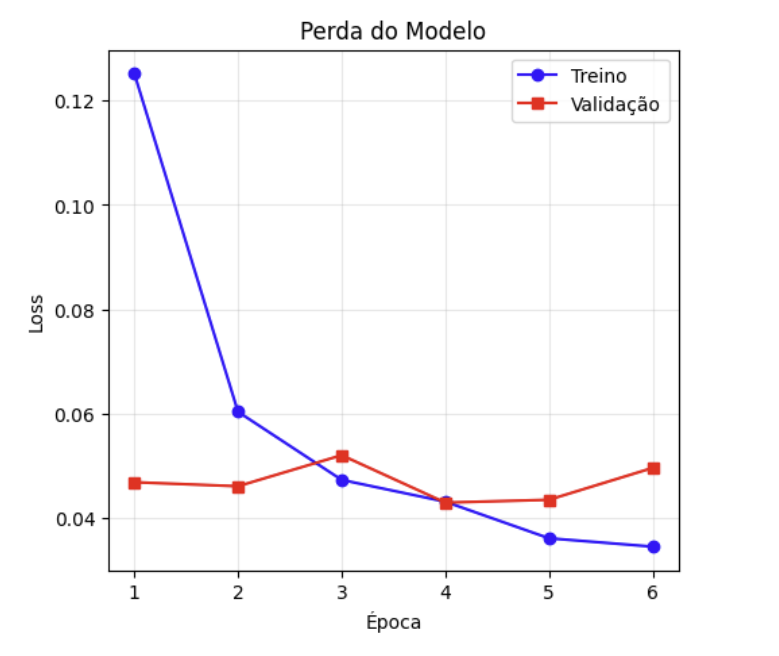
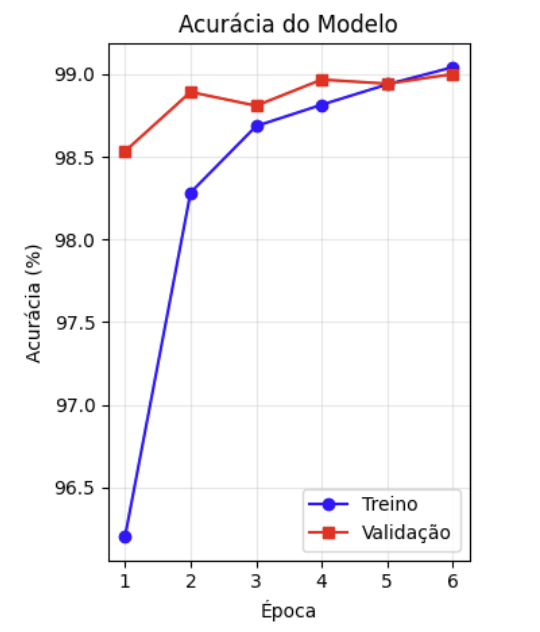



### **Modelo B -** SGD + momentum
 Agora mantendo a arquitetura anterior e fazendo alterações no otimizador. Utilizando:

In [ ]:
model = ConvNet().to(device)  # usa a rede que você já tinha
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


Além disso, aumentando as épocas para 15 pois o SGD converge mais devagar.

Os resultados da perda e da acurácia são:

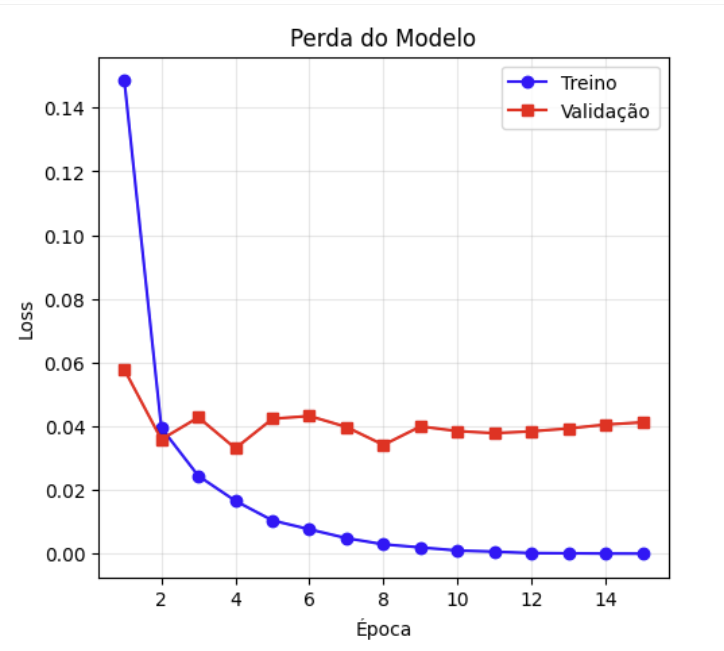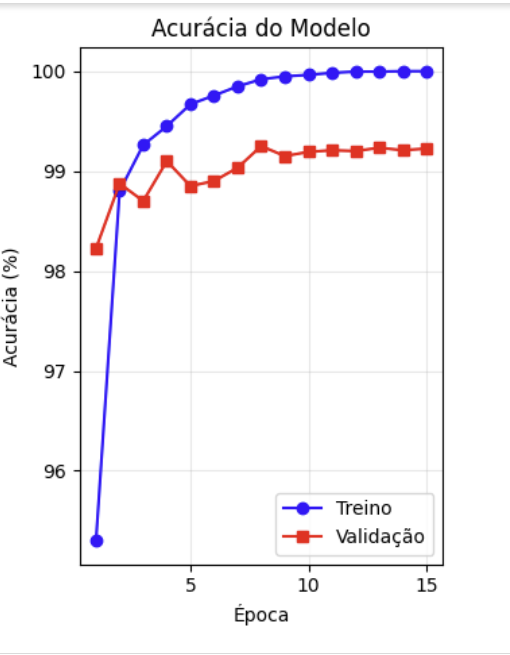


### **Modelo C -** Taxa de aprendizado + scheduler

Usando a mesma rede original, mas com AdamW e decaimento do LR.

In [ ]:
model = ConvNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=2)

E colocando o seguinte código após o loop de validação de cada época:

In [ ]:
scheduler.step(val_loss)

Os resultados da perda e da acurácia são:

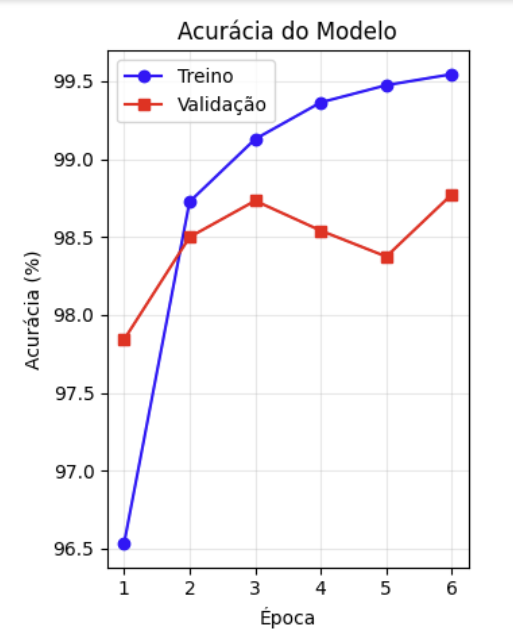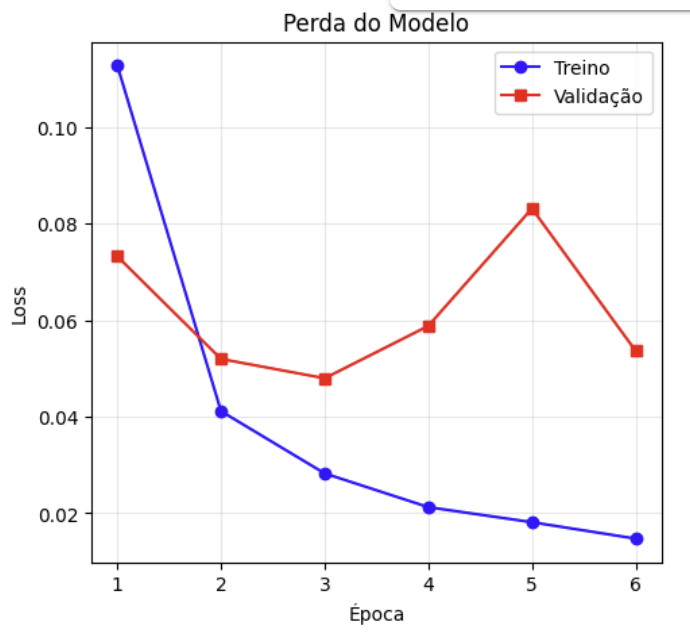

## **Exercício 6**

A diferença entre o **model.train()** e o **model.eval()**, se dá pelo fato que o **model.train()** ativa o modo de treino, em que as camadas como de Dropout e BactchNorm funcionam normalmente, desativando o neurônios aleatóriamente e usando as estatísticas  do batch atual para atualizar as médias/variâncias móveis, respectivamente. De outro modo, o **model.eval()** ativa o modo de avaliação, alterando os comportamentos da camada Dropout, que desativa completamente todos os neurônios ativos e a de BatchNorm, que usa as médias e variâncias calculadas durante o treinos, com estatísticas fixas.

No model.eval() é crucial utilizar o **torch.no_grad()**, porque desativa o cálcuko de gradientes, economizando memória, não armazenando os gradientes e nem construindo o grafo computacional, deixando as operações mais eficientes sem tracking de gradientes, tornando o processo mais rápido, além de previnir que os pesos sejam modificados acidentalmente.